# Bayesian Optimization for Logistic Regression for Customer Churn Prediction

This Jupyter Notebook provides steps to preprocess the data, tune hyperparameters using Bayesian Optimization, and train a Logestic Regression model for customer churn prediction using the processed dataset.

## Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
import joblib
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Load and Preprocess the Data

In [2]:
# Load the processed dataset
data_path = './enhanced_feature_data.csv' 
df = pd.read_csv(data_path)
df.drop(['tenure_bins'], axis=1, inplace=True)

# Define the feature columns and the target column
feature_columns = [col for col in df.columns if col != 'Churn']
X = df[feature_columns]
y = df['Churn']

## Split the data into training and testing sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Bayesian Optimization Hyperparameter Tuning

In [4]:
# Define the parameter search space for Logistic Regression
search_spaces = {
    'penalty': Categorical(['l1', 'l2']),
    'C': Real(0.01, 100, prior='log-uniform'),
    'solver': Categorical(['liblinear', 'saga']),
    'max_iter': Integer(100, 300)
}

search_spaces_elasticnet = {
    'penalty': Categorical(['elasticnet']),
    'C': Real(0.01, 100, prior='log-uniform'),
    'solver': Categorical(['saga']),
    'max_iter': Integer(100, 300),
    'l1_ratio': Real(0, 1, prior='uniform')
}

# Combine the search spaces
combined_search_spaces = [
    search_spaces,
    search_spaces_elasticnet
]

# Initialize Bayesian Optimization with cross-validation
bayes_search = BayesSearchCV(
    estimator=LogisticRegression(random_state=42),
    search_spaces=combined_search_spaces,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,  # Cross-validation splitting strategy
    n_jobs=-1,  # Use all available CPU cores
    verbose=2,
    random_state=42
)

# Fit the model
bayes_search.fit(X_train, y_train)

# Get the best parameters
best_params = bayes_search.best_params_
print(f'Best parameters found by Bayesian Optimization: {best_params}')

# Train the Logistic Regression Model with Best Parameters
best_log_reg_model = LogisticRegression(**best_params, random_state=42)
best_log_reg_model.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

LogisticRegression(C=0.3329080753723988, l1_ratio=1.0, max_iter=300,
                   penalty='elasticnet', random_state=42, solver='saga')

## Evaluate the Model

Accuracy: 0.82
Precision: 0.69
Recall: 0.58
F1-Score: 0.63
ROC AUC: 0.74


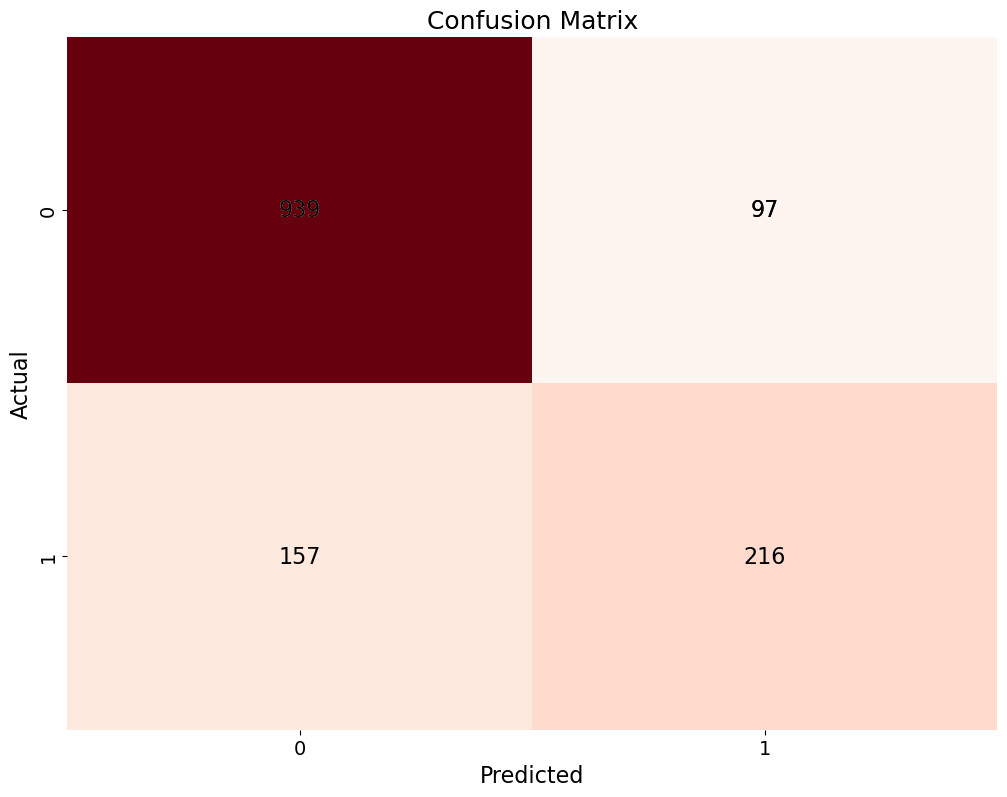

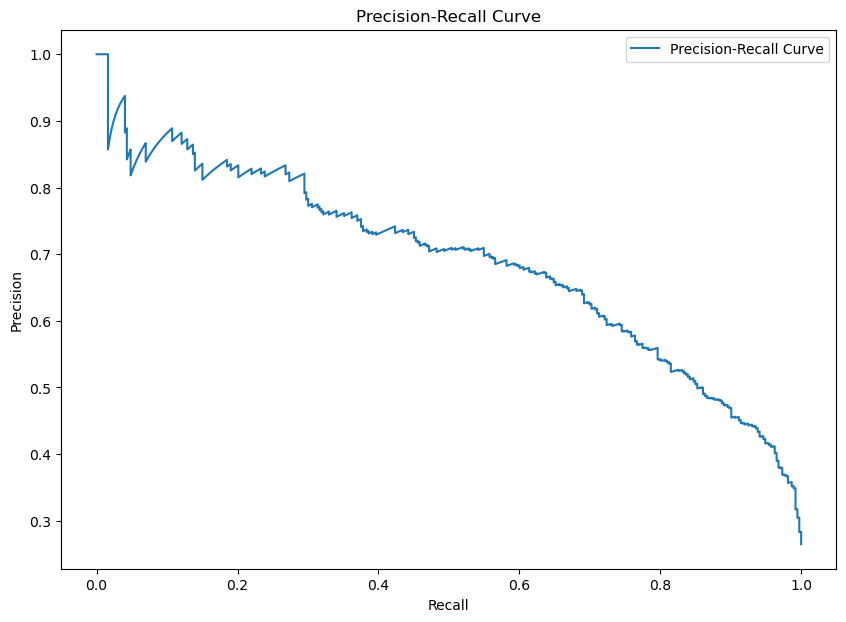

In [5]:
# Make predictions on the test set
y_pred = best_log_reg_model.predict(X_test)
y_pred_proba = best_log_reg_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')


# Confusion Matrix
plt.figure(figsize=(12, 9))  # Increase the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, annot_kws={"size": 16})  
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center", color="black", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 7))
plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

## Save Results

In [6]:
# Save evaluation metrics to a text file
with open('./LogisticRegression_EvaluationMetrics.txt', 'w') as f:
    f.write(f'Accuracy: {accuracy:.2f}\n')
    f.write(f'Precision: {precision:.2f}\n')
    f.write(f'Recall: {recall:.2f}\n')
    f.write(f'F1-Score: {f1:.2f}\n')
    f.write(f'ROC AUC: {roc_auc:.2f}\n')

# Save classification report to a text file
class_report = classification_report(y_test, y_pred)
with open('./LogisticRegression_ClassificationReport.txt', 'w') as f:
    f.write(class_report)
    
# Save confusion matrix as an image
plt.figure(figsize=(12, 9))  # Increase the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, annot_kws={"size": 16})  
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)

# Add text annotations
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center", color="black", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./LogisticRegression_ConfusionMatrix.png')
plt.close()

## Save the Model

In [7]:
model_filename = 'best_churn_model_log_reg.joblib'
joblib.dump(best_log_reg_model, model_filename)
print(f'Model saved to {model_filename}')

Model saved to best_churn_model_log_reg.joblib
